In [ ]:
import os
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
from skimage.exposure import match_histograms
import imageio

# IMAGE STICHING/ PANAROMA

Image stitching is a process that combines multiple images into a single image by slowly panning the camera across the scene to be captured.

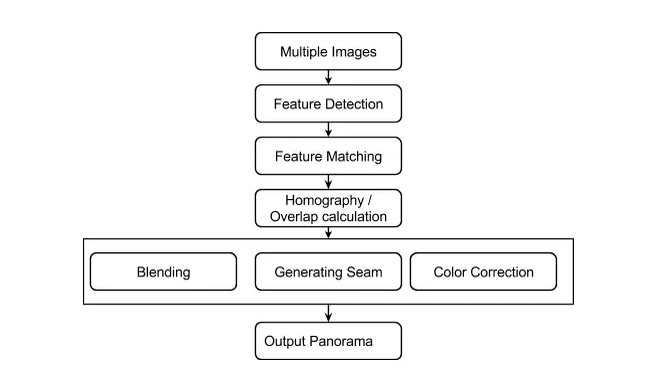

## Feature Detection

In [ ]:
img0 = cv2.imread('/content/drive/MyDrive/AI_Story/foto1A.jpg')
img1 = cv2.imread('/content/drive/MyDrive/AI_Story/foto1B.jpg')
# img2 = cv2.imread('/content/drive/MyDrive/AI_Story/2.jfif')

In [ ]:
gray0 = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)
gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)

### SIFT (Scale-invariant feature transform)

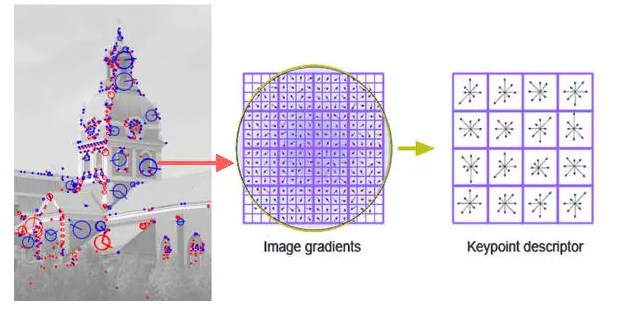

In [ ]:
sift = cv2.SIFT_create()

kp0, des0 = sift.detectAndCompute(gray0, None)
kp1, des1 = sift.detectAndCompute(gray1, None)

In [ ]:
img0_kp = cv2.drawKeypoints(img0, kp0, None)
img1_kp = cv2.drawKeypoints(img1, kp1, None)

In [ ]:
cv2_imshow(img0_kp)

In [ ]:
cv2_imshow(img1_kp)

### ORB (Oriented FAST and Rotated BRIEF)

In [ ]:
orb = cv2.ORB_create(nfeatures=2000)

kp00, des00 = orb.detectAndCompute(gray0, None)
kp01, des01 = orb.detectAndCompute(gray1, None)

In [ ]:
img00_kp = cv2.drawKeypoints(img0, kp00, None)
img01_kp = cv2.drawKeypoints(img1, kp01, None)

In [ ]:
cv2_imshow(img00_kp)

In [ ]:
cv2_imshow(img01_kp)

## Feature Matching

In [ ]:
def cal_ratio(matches):
    good = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good.append(m)

    print("Good matches:", len(good))
    return good

In [ ]:
def visual(img0, kp0, img1, kp1, good):
    img_match = cv2.drawMatches(
        img0, kp0,
        img1, kp1,
        good, None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    cv2_imshow(img_match)


### SIFT

#### Using BF (Brute Force)

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_L2)
matchesB1 = bf.knnMatch(des0, des1, k=2)


In [ ]:
goodB1 = cal_ratio(matchesB1)

In [ ]:
visual(img0_kp, kp0, img1_kp, kp1, goodB1)

#### Using FLANN MATCHING

In [ ]:
FLANN_INDEX_KDTREE = 1

index_params = dict(algorithm = FLANN_INDEX_KDTREE,
                    trees = 5)

search_params = dict(checks = 50)

flann = cv2.FlannBasedMatcher(index_params, search_params)

matchesF1 = flann.knnMatch(des0, des1, k=2)

In [ ]:
goodF1 = cal_ratio(matchesF1)

In [ ]:
visual(img0_kp, kp0, img1_kp, kp1, goodF1)

### ORB

#### BF

In [ ]:
bf = cv2.BFMatcher(cv2.NORM_HAMMING)
matchesB2 = bf.knnMatch(des00, des01, k=2)


In [ ]:
goodB2 = cal_ratio(matchesB2)

In [ ]:
visual(img00_kp, kp00, img01_kp, kp01, goodB2)

#### FLANN

In [ ]:
FLANN_INDEX_LSH = 6
index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 6, # 12
                   key_size = 12,     # 20
                   multi_probe_level = 1) #2
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)

matchesF2 = flann.knnMatch(des00, des01, k=2)

In [ ]:
goodF2 = cal_ratio(matchesF2)

In [ ]:
visual(img00_kp, kp00, img01_kp, kp01, goodF2)

## Homography

In [ ]:
def compute_homography(kpA, kpB, good):
    src_pts = np.float32(
        [kpA[m.queryIdx].pt for m in good]
    ).reshape(-1, 1, 2)

    dst_pts = np.float32(
        [kpB[m.trainIdx].pt for m in good]
    ).reshape(-1, 1, 2)

    H, mask = cv2.findHomography(
        src_pts,
        dst_pts,
        cv2.RANSAC,
        5.0
    )

    return H, mask

### SIFT

#### BF

In [ ]:
H01B, mask01B = compute_homography(kp0, kp1, goodB1)

print("Inliers:", mask01B.sum(), "/", len(mask01B))


In [ ]:
inlier_matches_1 = [
    goodB1[i] for i in range(len(goodB1)) if mask01B[i]
]

img_inliers_1 = cv2.drawMatches(
    img0, kp0,
    img1, kp1,
    inlier_matches_1, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

cv2_imshow(img_inliers_1)


#### FLANN

In [ ]:
H01F, mask01F = compute_homography(kp0, kp1, goodF1)

print("Inliers:", mask01F.sum(), "/", len(mask01F))


In [ ]:
inlier_matches_2 = [
    goodF1[i] for i in range(len(goodF1)) if mask01F[i]
]

img_inliers_2 = cv2.drawMatches(
    img0, kp0,
    img1, kp1,
    inlier_matches_2, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

cv2_imshow(img_inliers_2)


### ORB

#### BF

In [ ]:
H02B, mask02B = compute_homography(kp00, kp01, goodB2)

print("Inliers:", mask02B.sum(), "/", len(mask02B))


In [ ]:
inlier_matches_3 = [
    goodB2[i] for i in range(len(goodB2)) if mask02B[i]
]

img_inliers_3 = cv2.drawMatches(
    img0, kp00,
    img1, kp01,
    inlier_matches_3, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

cv2_imshow(img_inliers_3)


#### FLAN

In [ ]:
H02F, mask02F = compute_homography(kp00, kp01, goodF2)

print("Inliers:", mask02F.sum(), "/", len(mask02F))


In [ ]:
inlier_matches_4 = [
    goodF2[i] for i in range(len(goodF2)) if mask02F[i]
]

img_inliers_4 = cv2.drawMatches(
    img0, kp00,
    img1, kp01,
    inlier_matches_4, None,
    flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
)

cv2_imshow(img_inliers_4)


## Blending & Generating Seam & Color Correction

In [ ]:
def crop_black(warp):
    gray = cv2.cvtColor(warp, cv2.COLOR_BGR2GRAY)
    _, mask = cv2.threshold(gray, 1, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return warp

    cnt = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(cnt)

    return warp[y:y+h, x:x+w]


In [ ]:

def blend_images_canvas(base_img, warp_img, alpha=0.5):
    h, w = warp_img.shape[:2]

    canvas_base = np.zeros_like(warp_img)
    bh, bw = base_img.shape[:2]
    canvas_base[0:bh, 0:bw] = base_img

    mask_base = cv2.cvtColor(canvas_base, cv2.COLOR_BGR2GRAY) > 0
    mask_warp = cv2.cvtColor(warp_img, cv2.COLOR_BGR2GRAY) > 0
    overlap = mask_base & mask_warp

    result = warp_img.copy()
    for c in range(3):
        result[:, :, c] = np.where(
            overlap,
            (alpha * warp_img[:, :, c] + (1-alpha) * canvas_base[:, :, c]).astype(np.uint8),
            warp_img[:, :, c]
        )
    return result

In [ ]:
def post_process_warp(warp):
  warp = crop_black(warp)
  warp = match_histograms(warp, img1, channel_axis=-1)
  warp = blend_images_canvas(img1, warp, alpha=0.5)
  h, w = warp.shape[:2]
  margin = 50
  warp = warp[margin:h, margin:w-margin]
  return warp


### SIFT

#### BF

In [ ]:
h0, w0 = img0.shape[:2]
h1, w1 = img1.shape[:2]

result0 = cv2.warpPerspective(img0, H01B, (w0+w1, h1))
result0[0:h1, 0:w1] = img1

cv2_imshow(result0)

In [ ]:
result0 = post_process_warp(result0)
cv2_imshow(result0)



#### FLANN

In [ ]:
h0, w0 = img0.shape[:2]
h1, w1 = img1.shape[:2]

result1 = cv2.warpPerspective(img0, H01F, (w0+w1, h1))
result1[0:h1, 0:w1] = img1

cv2_imshow(result1)

In [ ]:
result1 = post_process_warp(result1)
cv2_imshow(result1)



### ORB

#### BF

In [ ]:
h0, w0 = img0.shape[:2]
h1, w1 = img1.shape[:2]

result2 = cv2.warpPerspective(img0, H02B, (w0+w1, h1))
result2[0:h1, 0:w1] = img1

cv2_imshow(result2)

In [ ]:
result2 = post_process_warp(result2)
cv2_imshow(result2)



#### FLAN

In [ ]:
h0, w0 = img0.shape[:2]
h1, w1 = img1.shape[:2]

result3 = cv2.warpPerspective(img0, H02F, (w0+w1, h1))
result3[0:h1, 0:w1] = img1

cv2_imshow(result3)

In [ ]:
result3 = post_process_warp(result3)
cv2_imshow(result3)



# DEMO WITH MORE THAN 2 IMAGES

ORB for feature detection

FLANN for feature matching

RANSAC for finding homogenous matrix

In [ ]:
def blend_images(base_img, warp_img, alpha=0.5):
    h = max(base_img.shape[0], warp_img.shape[0])
    w = max(base_img.shape[1], warp_img.shape[1])

    canvas_base = np.zeros((h, w, 3), dtype=np.uint8)
    canvas_warp = np.zeros((h, w, 3), dtype=np.uint8)

    canvas_base[0:base_img.shape[0], 0:base_img.shape[1]] = base_img
    canvas_warp[0:warp_img.shape[0], 0:warp_img.shape[1]] = warp_img

    mask_base = cv2.cvtColor(canvas_base, cv2.COLOR_BGR2GRAY) > 0
    mask_warp = cv2.cvtColor(canvas_warp, cv2.COLOR_BGR2GRAY) > 0
    overlap = mask_base & mask_warp

    result = canvas_base.copy()
    for c in range(3):
        result[:, :, c] = np.where(
            overlap,
            (alpha * canvas_warp[:, :, c] + (1-alpha) * canvas_base[:, :, c]).astype(np.uint8),
            np.where(mask_warp, canvas_warp[:, :, c], canvas_base[:, :, c])
        )
    return result


In [ ]:
def post_process(warp, base_img, alpha=0.5):
    warp = crop_black(warp)
    warp = match_histograms(warp, base_img, channel_axis=-1)
    warp = blend_images(base_img, warp, alpha=alpha)
    return warp


In [ ]:
def stitch_images(img_list, alpha=0.5):
    panorama = img_list[0]

    for i in range(1, len(img_list)):
        img = img_list[i]
        gray0 = cv2.cvtColor(panorama, cv2.COLOR_BGR2GRAY)
        gray1 = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        # --- Step 1: ORB keypoints + descriptors ---
        orb = cv2.ORB_create(2000)
        kp1, des1 = orb.detectAndCompute(gray0, None)
        kp2, des2 = orb.detectAndCompute(gray1, None)

        # --- Step 2: FLANN matching ---
        FLANN_INDEX_LSH = 6
        index_params= dict(algorithm = FLANN_INDEX_LSH,
                           table_number = 6,
                           key_size = 12,
                           multi_probe_level = 1)
        search_params = dict(checks=50)
        flann = cv2.FlannBasedMatcher(index_params,search_params)
        matches = flann.knnMatch(des1, des2, k=2)

        # --- Step 3: Ratio test ---
        good = []
        for m,n in matches:
            if m.distance < 0.75 * n.distance:
                good.append(m)
        print("Good matches:", len(good))

        # --- Step 4: RANSAC Homography ---
        if len(good) > 4:
            src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
            dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
            H, mask = cv2.findHomography(dst_pts, src_pts, cv2.RANSAC, 5.0)
        else:
            print("Not enough matches")
            continue
        print("Inliers:", mask.sum(), "/", len(mask))

        # --- Step 5: Warp img onto panorama ---
        h1, w1 = panorama.shape[:2]
        h2, w2 = img.shape[:2]
        result = cv2.warpPerspective(img, H, (w1 + w2, max(h1,h2)))
        result[0:h1, 0:w1] = panorama

        result = post_process(result, panorama, alpha=alpha)
        panorama = result

    return panorama


In [ ]:
#0213
img0 = cv2.imread('/content/drive/MyDrive/AI_Story/boat1.jpg')
img1 = cv2.imread('/content/drive/MyDrive/AI_Story/boat2.jpg')
img2 = cv2.imread('/content/drive/MyDrive/AI_Story/boat3.jpg')
img3 = cv2.imread('/content/drive/MyDrive/AI_Story/boat4.jpg')
#465
img4 = cv2.imread('/content/drive/MyDrive/AI_Story/a1.png')
img5 = cv2.imread('/content/drive/MyDrive/AI_Story/a2.png')
img6 = cv2.imread('/content/drive/MyDrive/AI_Story/a3.png')
img_list = [img0, img2, img1, img3 ]
panorama = stitch_images(img_list, alpha=0.5)
cv2_imshow(panorama)
